# Reproducing "Robust Fair Clustering: A Novel Fairness Attack and Defense Framework"

In [ ]:
%cd Fair-Clustering-Codebase/

In [2]:
import numpy as np
import random
from sklearn.model_selection import ParameterGrid
from zoopt import Dimension, Objective, Parameter, Opt
import warnings 
warnings.filterwarnings('ignore')

from fair_clustering.eval.functions import *
from fair_clustering.dataset import ExtendedYaleB, Office31, MNISTUSPS, DutchCensusData, OULADData, FairFace
from fair_clustering.algorithm import FairSpectral, FairKCenter, ScalableFairletDecomposition
import matplotlib.pyplot as plt
import os
from pyckmeans import CKmeans
from __future__ import division
from __future__ import print_function
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os
import json

!cp Consensus-Fair-Clustering/models.py ./
!cp Consensus-Fair-Clustering/utils.py ./
from models import GMLP, ClusteringLayer
from utils import get_A_r, sparse_mx_to_torch_sparse_tensor, target_distribution, aff

from scipy import sparse
from torch import nn

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'


## Downloading the datasets
The cell below downloads the Office-31 and the MNIST_USPS datasets. The Yale dataset cannnot be downloaded automatically, so it must be downloaded manually and placed in the `fair_clustering/raw_data/extended_yaleB/croppedYale` folder.

In [3]:
# # run this once to download all datasets (except the YaleB dataset, because the link is dead and it has to be downloaded manually)
_ = Office31(download=True, exclude_domain='amazon', use_feature=True)
_ = MNISTUSPS(download=True)

## Get precomputed_labels and best parameters for FairFace

In [3]:
name = 'FairFace'
dataset = FairFace()
X, y, s = dataset.data

n_clusters = len(np.unique(y))
print(n_clusters)

param_grid = {
    'alpha': [1, 10, 25, 50, 100],
    'beta': [10, 25, 50, 100]
}
grid = ParameterGrid(param_grid)

best_balance = float('inf')
best_params = None

# Run grid search
for params in grid:
    # Checking GCD of alpha and beta is 1
    if np.gcd(int(params['alpha']), int(params['beta'])) == 1:
        sfd = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=params['alpha'], beta=params['beta'])
        sfd.fit(X, s)
        
        current_balance = balance(sfd.labels_, X, s)
        
        if current_balance < best_balance:
            print("Found best balance so far")
            best_balance = current_balance
            best_params = params

print(f"Best balance: {best_balance}")
print(f"Best parameters: {best_params}")

sfd = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=best_params['alpha'], beta=best_params['beta'])
sfd.fit(X, s)

labels = sfd.labels_

np.save(f'labels_{name}.npy', labels)

(3641, 150528) (3641,) (3641,)
2
Found best balance so far
Best balance: 0.9683805399975648
Best parameters: {'alpha': 1, 'beta': 10}


## Attack

### Attack functions
In the original `Attack.ipynb` notebook, the authors did not provide code for the attack on the KFC algorithm. The cell below contains the same code as in the original notebook, but with the attack on the KFC algorithm added, and some minor changes to make it look cleaner.

In [4]:
# created a function for this instead of copying it in all other functions
def get_fair_clustering_algo(name, cl_algo, n_clusters, random_state):
  if cl_algo == 'FSC':
    if name == 'MNIST_USPS':
      metr_str = 'manhattan'
    else:
      metr_str = 'euclidean'
    fair_clustering_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str=metr_str, random_state=random_state)
  if cl_algo =='SFD':
    if name == 'DIGITS':      
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state) #5,2
    else:
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) #5,2
  # added for KFC with delta paremeter from the paper
  if cl_algo == 'KFC':
    fair_clustering_algo = FairKCenter(n_clusters=n_clusters, delta=0.1, random_state=random_state)

  return fair_clustering_algo

def attack_balance(solution):
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  fair_clustering_algo = get_fair_clustering_algo(name, cl_algo, n_clusters, random_state) 
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)

  return bal


def attack_entropy(solution):
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  fair_clustering_algo = get_fair_clustering_algo(name, cl_algo, n_clusters, random_state) 
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  ent = entropy(labels_sfd_eval, s_eval)

  return ent

def process_solution(sol):
  X_copy, s_copy, y_copy = X.copy(), s.copy(), y.copy()
  flipped_labels = sol.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  fair_clustering_algo = get_fair_clustering_algo(name, cl_algo, n_clusters, random_state)
  
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  y_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
    y_eval.append(y_copy[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)
  y_eval = np.array(y_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)
  ent = entropy(labels_sfd_eval, s_eval)
  accuracy = acc(y_eval, labels_sfd_eval)
  nmi_score = nmi(y_eval, labels_sfd_eval)

  return (bal, ent, accuracy, nmi_score)


def conduct_random_attack(size_sol):
  X_copy, s_copy, y_copy = X.copy(), s.copy(), y.copy()
  random.seed(None)
  flipped_labels = [random.randint(0,1) for _ in range(size_sol)]
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  fair_clustering_algo = get_fair_clustering_algo(name, cl_algo, n_clusters, random_state)

  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  y_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
    y_eval.append(y_copy[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)
  y_eval = np.array(y_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)
  ent = entropy(labels_sfd_eval, s_eval)
  accuracy = acc(y_eval, labels_sfd_eval)
  nmi_score = nmi(y_eval, labels_sfd_eval)

  return (bal, ent, accuracy, nmi_score)

### Running the attack
The cell below will run all the experiments for the attack. However, the cell itself is just for show as it would take hundreds of hours to run on consumer-grade hardware. Instead we have run the experiments in parallel on the Snellius supercomputer with 32 cores using the `Fair-Clustering-Codebase/reproduce-attack.py` and `reproduce-attack.job`.

In [2]:
# NOTE that it takes hundreds of hours to run this code sequentially, instead run the experiments in parallel on a high performance computing cluster
RUN_IN_NOTEBOOK = False
if not RUN_IN_NOTEBOOK:
  print("The experiments have been run on the Snellius supercomputer.")
else:
  objectives = ['balance', 'entropy']
  datasets = ['MNIST_USPS', 'Office-31', 'Yale', 'DIGITS', 'Dutch_Census_2001', 'OULAD', 'FairFace']
  algorithms = ['SFD', 'FSC', 'KFC']

  for objective in objectives:
    for cl_algo in algorithms:
      for name in datasets: 
        print(f"Dataset: {name}, Algorithm: {cl_algo}, Objective: {objective}")

        if name == 'Office-31':
          dataset = Office31(download=False, exclude_domain='amazon', use_feature=True)
          X, y, s = dataset.data
        elif name == 'MNIST_USPS':
          dataset = MNISTUSPS(download=False)
          print(dataset.dataset_dir)
          X, y, s = dataset.data
        elif name == 'Yale':
          dataset = ExtendedYaleB(download=False, resize=True)
          X, y, s = dataset.data
        elif name == 'DIGITS':
          X, y, s = np.load('X_' + name + '.npy'), np.load('y_' + name + '.npy'), np.load('s_' + name + '.npy')
        elif name == 'Dutch_Census_2001':
          dataset = DutchCensusData()
          X, y, s = dataset.data
        elif name == 'OULAD':
          dataset = OULADData()
          X, y, s = dataset.data
        elif name == 'FairFace':
          dataset = FairFace()
          X, y, s = dataset.data
          
        n_clusters = len(np.unique(y))
        print("# of clusters -> " + str(n_clusters))
        seeds = [150, 1, 4200, 424242, 1947, 355, 256, 7500, 99999, 18]
        n_trials = len(seeds)

        if name == 'Dutch_Census_2001' or name == 'OULAD' or name == 'FairFace':
          U_idx_full = random.sample(range(len(X)), k=int(len(X) * 0.5))
          V_idx_full = list(set(range(len(X))) - set(U_idx_full))
        else:
          U_idx_full, V_idx_full = np.load('U_idx_' + name + '.npy').tolist(), np.load('V_idx_' + name + '.npy').tolist()

        pre_attack_res = {
            0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
        }
        post_attack_res = {
            0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
        }
        random_attack_res = {
            0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
            7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
        }

        for percent, j in enumerate([int(0.125*len(U_idx_full)), int(0.25*len(U_idx_full)), int(0.375*len(U_idx_full)), int(0.5*len(U_idx_full)), int(0.625*len(U_idx_full)), int(0.75*len(U_idx_full)), int(0.875*len(U_idx_full)), int(len(U_idx_full))]):
          
          print(f"{percent}/7")

          U_idx = U_idx_full[:j]
          V_idx = V_idx_full

          for trial_idx in range(n_trials):
            random_state = seeds[trial_idx]
            
            fair_algo = get_fair_clustering_algo(name, cl_algo, n_clusters, random_state)
            fair_algo.fit(X, s)
            labels = fair_algo.labels_

            s_test = []
            X_test = []
            labels_test = []
            y_test = []
            for idx in V_idx:
              s_test.append(s[idx])
              X_test.append(X[idx])
              labels_test.append(labels[idx])
              y_test.append(y[idx])
            s_test = np.array(s_test)
            X_test = np.array(X_test)
            labels_test = np.array(labels_test)
            y_test = np.array(y_test)
            
            pre_attack_res[percent]['BALANCE'].append(balance(labels_test, X_test, s_test))
            pre_attack_res[percent]['ENTROPY'].append(entropy(labels_test, s_test))
            pre_attack_res[percent]['ACC'].append(acc(y_test, labels_test))
            pre_attack_res[percent]['NMI'].append(nmi(y_test, labels_test))
            
            dim_size = len(U_idx)
            dim = Dimension(dim_size, [[0, 1]]*dim_size, [False]*dim_size)

            if objective == 'balance':
              obj = Objective(attack_balance, dim)
            elif objective == 'entropy':
              obj = Objective(attack_entropy, dim)
            
            # added dynamic budget as the authors described in the comment below
            if name == 'MNIST_USPS':
              if cl_algo == 'SFD':
                budget = 50
              elif cl_algo == 'FSC':
                budget = 10
              elif cl_algo == 'KFC':
                budget = 10
            elif name == 'Office-31':
              budget = 20
            elif name == 'Yale':
              if cl_algo == 'SFD':
                budget = 20
              elif cl_algo == 'FSC':
                budget = 10
              elif cl_algo == 'KFC':
                budget = 10
            elif name == 'DIGITS':
              if cl_algo == 'SFD':
                budget = 25
              elif cl_algo == 'FSC':
                budget = 15
              elif cl_algo == 'KFC':
                budget = 15
            elif name == 'Dutch_Census_2001':
              if cl_algo == 'SFD':
                budget = 30
              elif cl_algo == 'FSC':
                budget = 12
              elif cl_algo == 'KFC':
                budget = 12
            elif name == 'OULAD':
              if cl_algo == 'SFD':
                budget = 30
              elif cl_algo == 'FSC':
                budget = 12
              elif cl_algo == 'KFC':
                budget = 12
            elif name == 'FairFace':
              if cl_algo == 'SFD':
                budget = 30
              elif cl_algo == 'FSC':
                budget = 12
              elif cl_algo == 'KFC':
                budget = 12
            solution = Opt.min(obj, Parameter(budget=budget)) # 10 for FSC for MNIST_USPS and 50 for SFD for MNIST_USPS || 20 for FSC for Office-31 and 20 for SFD for Office-31 || 10 for FSC for Yale and 20 for SFD for Yale || 15 for FSC for DIGITS and 25 for SFD for DIGITS
            
            pa_bal, pa_ent, pa_acc, pa_nmi = process_solution(solution)
            post_attack_res[percent]['BALANCE'].append(pa_bal)
            post_attack_res[percent]['ENTROPY'].append(pa_ent)
            post_attack_res[percent]['ACC'].append(pa_acc)
            post_attack_res[percent]['NMI'].append(pa_nmi)

            r_bal, r_ent, r_acc, r_nmi = conduct_random_attack(dim_size)
            random_attack_res[percent]['BALANCE'].append(r_bal)
            random_attack_res[percent]['ENTROPY'].append(r_ent)
            random_attack_res[percent]['ACC'].append(r_acc)
            random_attack_res[percent]['NMI'].append(r_nmi)
        
        with open('./reproduced-results/attack/' + name + '_' + cl_algo + '_' + objective + '.json', 'a') as f:
          json.dump({'pre_attack_res': pre_attack_res, 'post_attack_res': post_attack_res, 'random_attack_res': random_attack_res}, f)

The experiments have been run on the Snellius supercomputer.


### Visualizing the results
In order to visualize the results we take the results from both the attack on the balance and the attack on the entropy. This is different from the original paper where they only plot the best attack. The pre-attack results are the same because the same seed is used in both cases. The random attack is different, because different functions are used for both attacks, therefore we plot the mean of both random attacks. Finally, we plot two separate plots for the attack on the balance and the attack on the entropy.

SFD


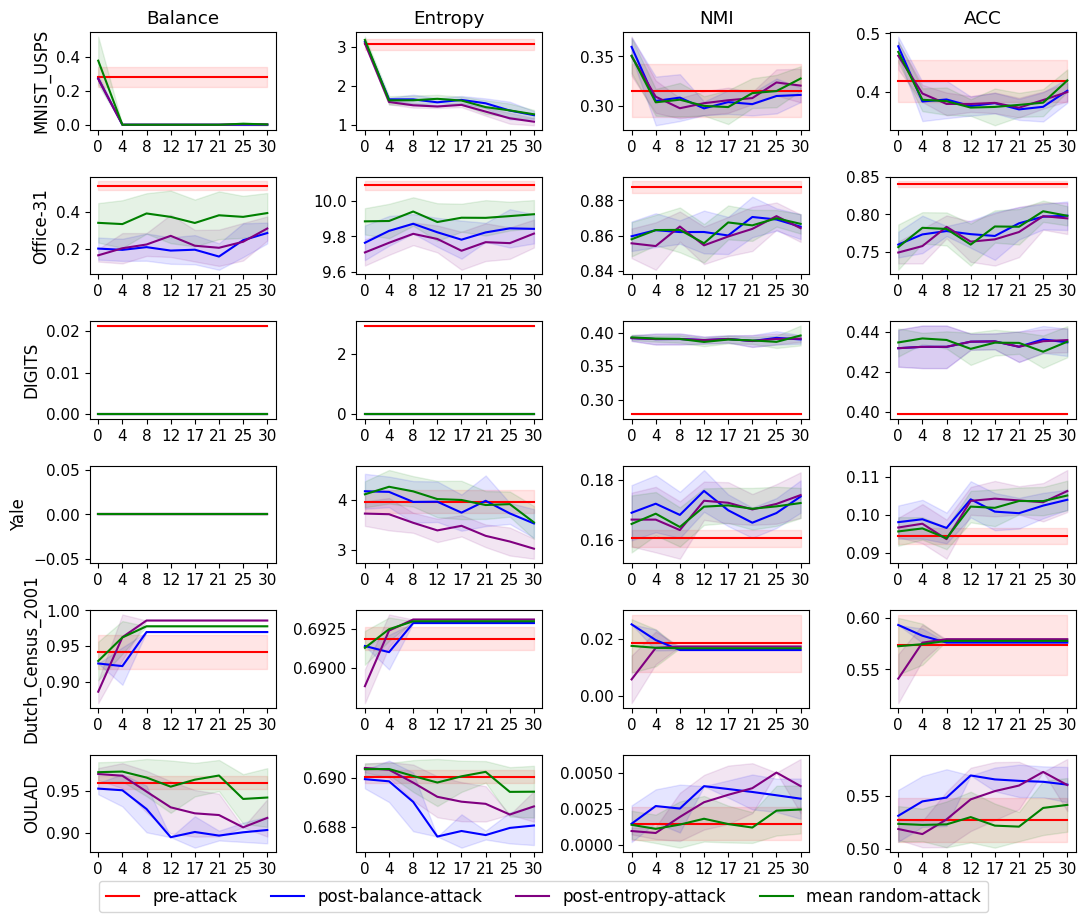

In [23]:

plt.rcParams.update({'font.size': 11})

for algorithm in ['SFD']: # 'SFD', 'FSC', 'KFC'        # Swap between attack algorithms to view their graphs
    print(algorithm)
    fig, axs = plt.subplots(6, 4, figsize=(11, 9))

    for i, dataset in enumerate(['MNIST_USPS', 'Office-31', 'DIGITS', 'Yale', 'Dutch_Census_2001', 'OULAD']):   #, 'FairFace']):
        try:
            bal_results = json.load(open('../reproduced-results/attack/' + dataset + '_' + algorithm + '_balance.json', 'r'))
            ent_results = json.load(open('../reproduced-results/attack/' + dataset + '_' + algorithm + '_entropy.json', 'r'))
        except:
            continue
        balance_pre = np.array([bal_results["pre_attack_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
        balance_pre_std = np.array([bal_results["pre_attack_res"][str(i)]['BALANCE'] for i in range(8)]).std(axis=1)
        bal_balance_post = np.array([bal_results["post_attack_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
        bal_balance_post_std = np.array([bal_results["post_attack_res"][str(i)]['BALANCE'] for i in range(8)]).std(axis=1)
        bal_balance_random =np.array( [bal_results["random_attack_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
        bal_balance_random_std = np.array([bal_results["random_attack_res"][str(i)]['BALANCE'] for i in range(8)]).std(axis=1)
        ent_balance_post = np.array([ent_results["post_attack_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
        ent_balance_post_std = np.array([ent_results["post_attack_res"][str(i)]['BALANCE'] for i in range(8)]).std(axis=1)
        ent_balance_random = np.array([ent_results["random_attack_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
        ent_balance_random_std = np.array([ent_results["random_attack_res"][str(i)]['BALANCE'] for i in range(8)]).std(axis=1)
        balance_random = (bal_balance_random + ent_balance_random) / 2
        balance_random_std = (bal_balance_random_std + ent_balance_random_std) / 2

        entropy_pre = np.array([bal_results["pre_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
        entropy_pre_std = np.array([bal_results["pre_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).std(axis=1)
        bal_entropy_post = np.array([bal_results["post_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
        bal_entropy_post_std = np.array([bal_results["post_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).std(axis=1)
        bal_entropy_random = np.array([bal_results["random_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
        bal_entropy_random_std = np.array([bal_results["random_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).std(axis=1)
        ent_entropy_post = np.array([ent_results["post_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
        ent_entropy_post_std = np.array([ent_results["post_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).std(axis=1)
        ent_entropy_random = np.array([ent_results["random_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
        ent_entropy_random_std = np.array([ent_results["random_attack_res"][str(i)]['ENTROPY'] for i in range(8)]).std(axis=1)
        entropy_random = (bal_entropy_random + ent_entropy_random) / 2
        entropy_random_std = (bal_entropy_random_std + ent_entropy_random_std) / 2

        nmi_pre = np.array([bal_results["pre_attack_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
        nmi_pre_std = np.array([bal_results["pre_attack_res"][str(i)]['NMI'] for i in range(8)]).std(axis=1)
        bal_nmi_post = np.array([bal_results["post_attack_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
        bal_nmi_post_std = np.array([bal_results["post_attack_res"][str(i)]['NMI'] for i in range(8)]).std(axis=1)
        bal_nmi_random = np.array([bal_results["random_attack_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
        bal_nmi_random_std = np.array([bal_results["random_attack_res"][str(i)]['NMI'] for i in range(8)]).std(axis=1)
        ent_nmi_post = np.array([ent_results["post_attack_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
        ent_nmi_post_std = np.array([ent_results["post_attack_res"][str(i)]['NMI'] for i in range(8)]).std(axis=1)
        ent_nmi_random = np.array([ent_results["random_attack_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
        ent_nmi_random_std = np.array([ent_results["random_attack_res"][str(i)]['NMI'] for i in range(8)]).std(axis=1)
        nmi_random = (bal_nmi_random + ent_nmi_random) / 2
        nmi_random_std = (bal_nmi_random_std + ent_nmi_random_std) / 2

        acc_pre = np.array([bal_results["pre_attack_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
        acc_pre_std = np.array([bal_results["pre_attack_res"][str(i)]['ACC'] for i in range(8)]).std(axis=1)
        bal_acc_post = np.array([bal_results["post_attack_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
        bal_acc_post_std = np.array([bal_results["post_attack_res"][str(i)]['ACC'] for i in range(8)]).std(axis=1)
        bal_acc_random = np.array([bal_results["random_attack_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
        bal_acc_random_std = np.array([bal_results["random_attack_res"][str(i)]['ACC'] for i in range(8)]).std(axis=1)
        ent_acc_post = np.array([ent_results["post_attack_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
        ent_acc_post_std = np.array([ent_results["post_attack_res"][str(i)]['ACC'] for i in range(8)]).std(axis=1)
        ent_acc_random = np.array([ent_results["random_attack_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
        ent_acc_random_std = np.array([ent_results["random_attack_res"][str(i)]['ACC'] for i in range(8)]).std(axis=1)
        acc_random = (bal_acc_random + ent_acc_random) / 2
        acc_random_std = (bal_acc_random_std + ent_acc_random_std) / 2


        axs[0, 0].set_title('Balance')
        axs[0, 1].set_title('Entropy')
        axs[0, 2].set_title('NMI')
        axs[0, 3].set_title('ACC')

        axs[i, 0].set_ylabel(dataset, fontsize=12)
        xticks = np.arange(8)
        labels = np.linspace(0, 30, 8, dtype=int)

        axs[i, 0].plot(balance_pre, label='pre-attack', color='red')
        axs[i, 0].fill_between(xticks, balance_pre - balance_pre_std, balance_pre + balance_pre_std, color='red', alpha=0.1)
        axs[i, 0].plot(bal_balance_post, label='post-balance-attack', color='blue')
        axs[i, 0].fill_between(xticks, bal_balance_post - bal_balance_post_std, bal_balance_post + bal_balance_post_std, color='blue', alpha=0.1)
        axs[i, 0].plot(ent_balance_post, label='post-entropy-attack', color='purple')
        axs[i, 0].fill_between(xticks, ent_balance_post - ent_balance_post_std, ent_balance_post + ent_balance_post_std, color='purple', alpha=0.1)
        axs[i, 0].plot(balance_random, label='mean random-attack', color='green')
        axs[i, 0].fill_between(xticks, balance_random - balance_random_std, balance_random + balance_random_std, color='green', alpha=0.1)
        axs[i, 0].set_xticks(xticks)
        axs[i, 0].set_xticklabels(labels)

        axs[i, 1].plot(entropy_pre, label='pre-attack', color='red')
        axs[i, 1].fill_between(xticks, entropy_pre - entropy_pre_std, entropy_pre + entropy_pre_std, color='red', alpha=0.1)
        axs[i, 1].plot(bal_entropy_post, label='post-balance-attack', color='blue')
        axs[i, 1].fill_between(xticks, bal_entropy_post - bal_entropy_post_std, bal_entropy_post + bal_entropy_post_std, color='blue', alpha=0.1)
        axs[i, 1].plot(ent_entropy_post, label='post-entropy-attack', color='purple')
        axs[i, 1].fill_between(xticks, ent_entropy_post - ent_entropy_post_std, ent_entropy_post + ent_entropy_post_std, color='purple', alpha=0.1)
        axs[i, 1].plot(entropy_random, label='mean random-attack', color='green')
        axs[i, 1].fill_between(xticks, entropy_random - entropy_random_std, entropy_random + entropy_random_std, color='green', alpha=0.1)
        axs[i, 1].set_xticks(xticks)
        axs[i, 1].set_xticklabels(labels)

        axs[i, 2].plot(nmi_pre, label='pre', color='red')
        axs[i, 2].fill_between(xticks, nmi_pre - nmi_pre_std, nmi_pre + nmi_pre_std, color='red', alpha=0.1)
        axs[i, 2].plot(bal_nmi_post, label='post-balance-attack', color='blue')
        axs[i, 2].fill_between(xticks, bal_nmi_post - bal_nmi_post_std, bal_nmi_post + bal_nmi_post_std, color='blue', alpha=0.1)
        axs[i, 2].plot(ent_nmi_post, label='post-entropy-attack', color='purple')
        axs[i, 2].fill_between(xticks, ent_nmi_post - ent_nmi_post_std, ent_nmi_post + ent_nmi_post_std, color='purple', alpha=0.1)
        axs[i, 2].plot(nmi_random, label='mean random-attack', color='green')
        axs[i, 2].fill_between(xticks, nmi_random - nmi_random_std, nmi_random + nmi_random_std, color='green', alpha=0.1)
        axs[i, 2].set_xticks(xticks)
        axs[i, 2].set_xticklabels(labels)

        axs[i, 3].plot(acc_pre, label='pre-attack', color='red')
        axs[i, 3].fill_between(xticks, acc_pre - acc_pre_std, acc_pre + acc_pre_std, color='red', alpha=0.1)
        axs[i, 3].plot(bal_acc_post, label='post-balance-attack', color='blue')
        axs[i, 3].fill_between(xticks, bal_acc_post - bal_acc_post_std, bal_acc_post + bal_acc_post_std, color='blue', alpha=0.1)
        axs[i, 3].plot(ent_acc_post, label='post-entropy-attack', color='purple')
        axs[i, 3].fill_between(xticks, ent_acc_post - ent_acc_post_std, ent_acc_post + ent_acc_post_std, color='purple', alpha=0.1)
        axs[i, 3].plot(acc_random, label='mean random-attack', color='green')
        axs[i, 3].fill_between(xticks, acc_random - acc_random_std, acc_random + acc_random_std, color='green', alpha=0.1)
        axs[i, 3].set_xticks(xticks)
        axs[i, 3].set_xticklabels(labels)

    # fig.suptitle(algorithm, fontsize=14)
    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.03), fontsize=12)
    plt.tight_layout()
    plt.show()
    

## Defense

In [3]:
# Remember we need the model class in the same directory to load our models so copy those over
!cp Consensus-Fair-Clustering/models.py ./
!cp Consensus-Fair-Clustering/utils.py ./
!ls

Consensus-Fair-Clustering  V_idx_Office-31.npy	reproduce-attack.py
U_idx_DIGITS.npy	   V_idx_TOY.npy	reproduce-defense.py
U_idx_MNIST_USPS.npy	   V_idx_Yale.npy	s_DIGITS.npy
U_idx_Office-31.npy	   X_DIGITS.npy		s_TOY.npy
U_idx_TOY.npy		   X_TOY.npy		utils.py
U_idx_Yale.npy		   __pycache__		y_DIGITS.npy
V_idx_DIGITS.npy	   fair_clustering	y_TOY.npy
V_idx_MNIST_USPS.npy	   models.py


In [ ]:
def Ncontrast(x_dis, adj_label, tau = 1):
    """
    compute the Ncontrast loss
    """
    x_dis = torch.exp( tau * x_dis)
    x_dis_sum = torch.sum(x_dis, 1)
    x_dis_sum_pos = torch.sum(x_dis*adj_label, 1)
    loss = -torch.log(x_dis_sum_pos * (x_dis_sum**(-1))+1e-8).mean()
    return loss

def get_batch(batch_size, idx_train, adj_label, features):
    """
    get a batch of feature & adjacency matrix
    """
    rand_indx = torch.tensor(np.random.choice(np.arange(adj_label.shape[0]), batch_size)).type(torch.long).cuda()
    rand_indx[0:len(idx_train)] = idx_train
    features_batch = features[rand_indx]
    adj_label_batch = adj_label[rand_indx,:][:,rand_indx]
    return features_batch, adj_label_batch

def train(model, CL, optimizer, s_idx0, s_idx1, bs, KL_div, tau, alpha, beta, idx_train, adj_label, features, Y, MSEL):
    features_batch, adj_label_batch = get_batch(bs, idx_train, adj_label, features)
    model.train()
    CL.train()

    optimizer.zero_grad()
    output, x_dis, embeddings = model(features_batch)
    
    output = CL(embeddings)
    output0, output1 = output[s_idx0], output[s_idx1]
    target0, target1 = target_distribution(output0).detach(), target_distribution(output1).detach()
    fair_loss = 0.5 * KL_div(output0.log(), target0) + 0.5 * KL_div(output1.log(), target1)

    loss_Ncontrast = Ncontrast(x_dis, adj_label_batch, tau = tau)

    predict0, predict1 = Y[s_idx0], Y[s_idx1]
    partition_loss = 0.5 * MSEL(aff(output0), aff(predict0)) + 0.5 * MSEL(aff(output1), aff(predict1))

    loss_train = alpha * fair_loss + loss_Ncontrast + beta * partition_loss

    loss_train.backward()
    optimizer.step()
    return 

def ConsensusFairClusteringHelper(name, X_in, s_in, y_in, save, order=1, lr=0.01, weight_decay=5e-3, alpha=50.0, num_hidden=256, bs=3800, tau=2, epochs=3000, dropout=0.6):
  k = len(np.unique(y_in))

  if name == 'Office-31':
    beta = 100.0 
    alpha = 1.0 
    order = 1
  if name == 'MNIST_USPS':
    beta = 25.0 
    alpha = 100.0 
    order = 2
  if name == 'Yale':
    beta = 10.0 
    alpha = 50.0 
    order = 2
  if name == 'DIGITS':
    beta = 50.0 
    alpha = 10.0 
    order = 2
    num_hidden=36
  if name == 'FairFace':
    beta = 10.0
    alpha = 1.0
    order = 1


  ckm = CKmeans(k=k, n_rep=100, p_samp=0.5, p_feat=0.5, random_state=42)
  ckm.fit(X_in)
  ckm_res = ckm.predict(X_in, return_cls=True)


  adj, features, labels = ckm_res.cmatrix, X_in, y_in
  adj = sparse.csr_matrix(adj)
  adj = sparse_mx_to_torch_sparse_tensor(adj).float()
  features = torch.FloatTensor(features).float()
  labels = torch.LongTensor(labels)
  idx_train = np.array(range(len(features)))
  idx_train = torch.LongTensor(idx_train)

  adj_label = get_A_r(adj, order)
  adj, adj_label, features, idx_train = adj.cuda(), adj_label.cuda(), features.cuda(), idx_train.cuda()

  s_idx0, s_idx1 = [], []
  for i in range(len(s_in)):
    if s_in[i] == 0:
      s_idx0.append(i)
    elif s_in[i] == 1:
      s_idx1.append(i) 


  L = np.load('Consensus-Fair-Clustering/precomputed_labels/labels_' + name + '.npy')
  Y = np.zeros((len(s), k))
  for i,l in enumerate(L):
    Y[i,l] = 1.0
  Y = torch.FloatTensor(Y).float().cuda()
  MSEL = nn.MSELoss(reduction="sum")

  torch.manual_seed(42)
  torch.use_deterministic_algorithms(True)
  model = GMLP(nfeat=features.shape[1],
              nhid=num_hidden,
              nclass=labels.max().item() + 1,
              dropout=dropout,
              )

  torch.manual_seed(42)
  torch.use_deterministic_algorithms(True)
  CL = ClusteringLayer(cluster_number=k, hidden_dimension=num_hidden).cuda()
  
  optimizer = optim.Adam(model.get_parameters() + CL.get_parameters(), lr=lr, weight_decay=weight_decay)
  KL_div = nn.KLDivLoss(reduction="sum")
  model.cuda()
  features = features.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()

  for epoch in tqdm(range(epochs)):
    train(model, CL, optimizer, s_idx0, s_idx1, bs, KL_div, tau, alpha, beta, idx_train, adj_label, features, Y, MSEL)

  model.eval()
  logits, embeddings = model(features)
  CL.eval()
  preds = CL(embeddings)
  preds = preds.cpu().detach().numpy()
  pred_labels = np.argmax(preds, axis=1)

  return pred_labels

def ConsensusFairClustering(name, X_in, s_in, y_in, save):
  name_bal = {'Office-31': 0.5, 'MNIST_USPS': 0.3, 'DIGITS': 0.1, 'Yale': 0.1, 'FairFace': 0.1}
  while True: #Sometimes the model optimizes for a local minima which is why we can run enough times to get a good representation learnt
    cfc_labels = ConsensusFairClusteringHelper(name, X_in, s_in, y_in, save)
    if balance(cfc_labels, X_in, s_in) >= name_bal[name]: #threshold -> 0.5 for Office-31 and 0.3 (0.4) for MNIST_USPS and 0.1 for DIGITS and 0.1 for Yale
      break
  print("\nCompleted CFC model training.")
  return cfc_labels


def attack_balance(solution):
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  labels_sfd = ConsensusFairClustering(name, X_copy, s_copy, y, save=False)
  
  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)

  return bal



def process_solution(sol):
  X_copy, s_copy, y_copy = X.copy(), s.copy(), y.copy()
  flipped_labels = sol.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  labels_sfd = ConsensusFairClustering(name, X_copy, s_copy, y, save=False)

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  y_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
    y_eval.append(y_copy[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)
  y_eval = np.array(y_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)
  ent = entropy(labels_sfd_eval, s_eval)
  accuracy = acc(y_eval, labels_sfd_eval)
  nmi_score = nmi(y_eval, labels_sfd_eval)

  return (bal, ent, accuracy, nmi_score)


def attack_entropy(solution):
  "Added this function because this was not researched in the original paper"
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  labels_sfd = ConsensusFairClustering(name, X_copy, s_copy, y, save=False)

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  ent = entropy(labels_sfd_eval, s_eval)

  return ent

In [ ]:

# NOTE that it takes hundreds of hours to run this code sequentially, instead run the experiments in parallel on a high performance computing cluster
RUN_IN_NOTEBOOK = False
if not RUN_IN_NOTEBOOK:
  print("The experiments have been run on the Snellius supercomputer.")
else:
  objectives = ['balance', 'entropy']
  datasets = ['MNIST_USPS', 'Office-31', 'Yale', 'DIGITS', 'FairFace']

  for objective in objectives:
    for name in datasets: 
      
      if name == 'Office-31':
        dataset = Office31(download=False, exclude_domain='amazon', use_feature=True)
        X, y, s = dataset.data
      elif name == 'MNIST_USPS':
        dataset = MNISTUSPS(download=False)
        X, y, s = dataset.data
      elif name == 'Yale':
        dataset = ExtendedYaleB(download=False, resize=True)
        X, y, s = dataset.data
      elif name == 'DIGITS':
        X, y, s = np.load('X_' + name + '.npy'), np.load('y_' + name + '.npy'), np.load('s_' + name + '.npy')
      elif name == 'FairFace':
        dataset = FairFace()
        X, y, s = dataset.data

      print(f"Dataset: {name}, Algorithm: CFC, Objective: {objective}")

      n_clusters = len(np.unique(y))
      print("# of clusters -> " + str(n_clusters))
      n_trials = 1

      if name == 'FairFace':
        U_idx_full = random.sample(range(len(X)), k=int(len(X) * 0.5))
        V_idx_full = list(set(range(len(X))) - set(U_idx_full))
      else:
        U_idx_full, V_idx_full = np.load('U_idx_' + name + '.npy').tolist(), np.load('V_idx_' + name + '.npy').tolist()

      cfc_pre_res = {
          0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
      }


      cfc_post_res = {
          0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
          7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
      }

      for percent, j in enumerate([int(0.125*len(U_idx_full)), int(0.25*len(U_idx_full)), int(0.375*len(U_idx_full)), int(0.5*len(U_idx_full)), int(0.625*len(U_idx_full)), int(0.75*len(U_idx_full)), int(0.875*len(U_idx_full)), int(len(U_idx_full))]):
        print(f"{percent}/7")
        U_idx = U_idx_full[:j]
        V_idx = V_idx_full

        for trial_idx in range(n_trials):

          labels = ConsensusFairClustering(name, X, s, y, save=False)

          s_test = []
          X_test = []
          labels_test = []
          y_test = []
          for idx in V_idx:
            s_test.append(s[idx])
            X_test.append(X[idx])
            labels_test.append(labels[idx])
            y_test.append(y[idx])
          s_test = np.array(s_test)
          X_test = np.array(X_test)
          labels_test = np.array(labels_test)
          y_test = np.array(y_test)

          cfc_pre_res[percent]['BALANCE'].append(balance(labels_test, X_test, s_test))
          cfc_pre_res[percent]['ENTROPY'].append(entropy(labels_test, s_test))
          cfc_pre_res[percent]['ACC'].append(acc(y_test, labels_test))
          cfc_pre_res[percent]['NMI'].append(nmi(y_test, labels_test))

          dim_size = len(U_idx)
          dim = Dimension(dim_size, [[0, 1]]*dim_size, [False]*dim_size)

          # added this instead of fixed objective balance
          if objective == 'balance':
            obj = Objective(attack_balance, dim)
          elif objective == 'entropy':
            obj = Objective(attack_entropy, dim)
          
          solution = Opt.min(obj, Parameter(budget=5)) 

          pa_bal, pa_ent, pa_acc, pa_nmi = process_solution(solution)

          cfc_post_res[percent]['BALANCE'].append(pa_bal)
          cfc_post_res[percent]['ENTROPY'].append(pa_ent)
          cfc_post_res[percent]['ACC'].append(pa_acc)
          cfc_post_res[percent]['NMI'].append(pa_nmi)

      with open('./reproduced-results/defense/' + name + '_' + cl_algo + '_' + objective + '.json', 'a') as f:
        json.dump({'cfc_pre_res': cfc_pre_res, 'cfc_post_res': cfc_post_res}, f)

The experiments have been run on the Snellius supercomputer.


### Visualizing the results

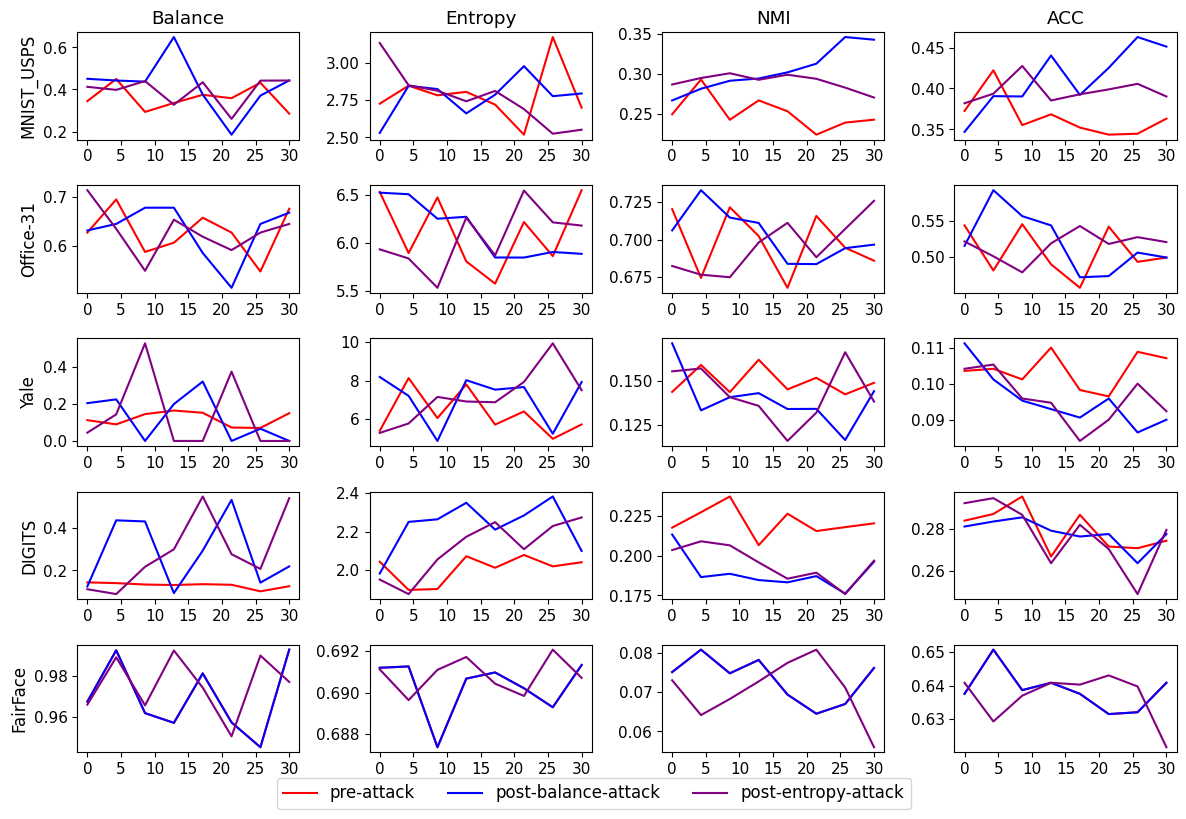

In [5]:
plt.rcParams.update({'font.size': 11})

fig, axs = plt.subplots(5, 4, figsize=(12, 8))

for i, dataset in enumerate(['MNIST_USPS', 'Office-31', 'Yale', 'DIGITS', 'FairFace']):
    try:
        bal_results = json.load(open('../reproduced-results/defense/' + dataset + '_balance.json', 'r'))
        ent_results = json.load(open('../reproduced-results/defense/' + dataset + '_entropy.json', 'r'))
    except:
        continue

    balance_pre = np.array([bal_results["cfc_pre_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
    bal_balance_post = np.array([bal_results["cfc_post_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)
    ent_balance_post = np.array([ent_results["cfc_post_res"][str(i)]['BALANCE'] for i in range(8)]).mean(axis=1)

    entropy_pre = np.array([bal_results["cfc_pre_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
    bal_entropy_post = np.array([bal_results["cfc_post_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)
    ent_entropy_post = np.array([ent_results["cfc_post_res"][str(i)]['ENTROPY'] for i in range(8)]).mean(axis=1)

    nmi_pre = np.array([bal_results["cfc_pre_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
    bal_nmi_post = np.array([bal_results["cfc_post_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)
    ent_nmi_post = np.array([ent_results["cfc_post_res"][str(i)]['NMI'] for i in range(8)]).mean(axis=1)

    acc_pre = np.array([bal_results["cfc_pre_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
    bal_acc_post = np.array([bal_results["cfc_post_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)
    ent_acc_post = np.array([ent_results["cfc_post_res"][str(i)]['ACC'] for i in range(8)]).mean(axis=1)


    axs[0, 0].set_title('Balance')
    axs[0, 1].set_title('Entropy')
    axs[0, 2].set_title('NMI')
    axs[0, 3].set_title('ACC')

    axs[i, 0].set_ylabel(dataset, fontsize=12)
    xticks = np.linspace(0, 7, 7)
    labels = np.linspace(0, 30, 7, dtype=int)

    axs[i, 0].plot(balance_pre, label='pre-attack', color='red')
    axs[i, 0].plot(bal_balance_post, label='post-balance-attack', color='blue')
    axs[i, 0].plot(ent_balance_post, label='post-entropy-attack', color='purple')
    axs[i, 0].set_xticks(xticks)
    axs[i, 0].set_xticklabels(labels)

    axs[i, 1].plot(entropy_pre, label='pre-attack', color='red')
    axs[i, 1].plot(bal_entropy_post, label='post-balance-attack', color='blue')
    axs[i, 1].plot(ent_entropy_post, label='post-entropy-attack', color='purple')
    axs[i, 1].set_xticks(xticks)
    axs[i, 1].set_xticklabels(labels)

    axs[i, 2].plot(nmi_pre, label='pre', color='red')
    axs[i, 2].plot(bal_nmi_post, label='post-balance-attack', color='blue')
    axs[i, 2].plot(ent_nmi_post, label='post-entropy-attack', color='purple')
    axs[i, 2].set_xticks(xticks)
    axs[i, 2].set_xticklabels(labels)

    axs[i, 3].plot(acc_pre, label='pre-attack', color='red')
    axs[i, 3].plot(bal_acc_post, label='post-balance-attack', color='blue')
    axs[i, 3].plot(ent_acc_post, label='post-entropy-attack', color='purple')
    axs[i, 3].set_xticks(xticks)
    axs[i, 3].set_xticklabels(labels)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.03), fontsize=12)
plt.tight_layout()
plt.show()
